# Sentimental Analysis of Reviews

This is a text classificaton (sentimental analysis) model using NLP and Neural Networks. 

We will use the [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences) from the UCI Machine Learning Repository to test and train our model. It contains sentences labelled with positive or negative sentiment, extracted from reviews of products, movies, and restaurants.

In [27]:
import pandas as pd

filepath_dict = {
    'yelp':   'data/sentiment_analysis/yelp.txt',
    'amazon': 'data/sentiment_analysis/amazon.txt',
    'imdb':   'data/sentiment_analysis/imdb.txt'
}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source                                               # Add another column filled with the source name
    df_list.append(df)

# Create a data frame by concatenating all the three data sources
df = pd.concat(df_list)
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


## Defining a Baseline model

We will use a simple `Bag of Words` model to convert the sentences to a vocabulary, and then embed each sentence where each index represents the frequency of the word in that sentence for the word at that index in the vocabulary. BOW is used to represent the sequence of words (sentence) as single feature vector. We will use a linear-regression model to classify the same. 

- `CountVectorizer` performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word.

In [28]:
# Analysis for Yelp Dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

# Divide into a 25% test set and 75% training set
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

# Train the BOW model
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

X_train
# The data has 750 sentences with a vocabulary of 1500-2500 unique words

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [29]:
# Analysis for each data source one at a time
for source in df["source"].unique():
    df_source = df[df["source"] == source]
    sentences = df_source["sentence"].values
    y = df_source["label"].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000
    )

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print("Accuracy for {} data: {:.4f}".format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Neural Networks

We use `Keras` to create a multiple Neural Networks with different encodings and embeddings in the upcoming sections.

### Neural Network with Count Vectorization Encoding

Each sentence is encoded into a fixed number of dimensions (equal to the size of the vocabulary) and the values represent the frequency of the word in the sentence. This model has the following architecture:
- Layer 1 with `10` nodes, connected to each word found in the vocabulary in our BOW model
- Layer 2 with `1` output node, connected to the layer 1 neurons

In [30]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with some baseline parameters
# They do not accept the training, but only the testing
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                25060     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 25071 (97.93 KB)
Trainable params: 25071 (97.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Create a charitng utility to plot the graphs for accuracy and loss
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

Training Accuracy: 1.0000
Testing Accuracy:  0.7861


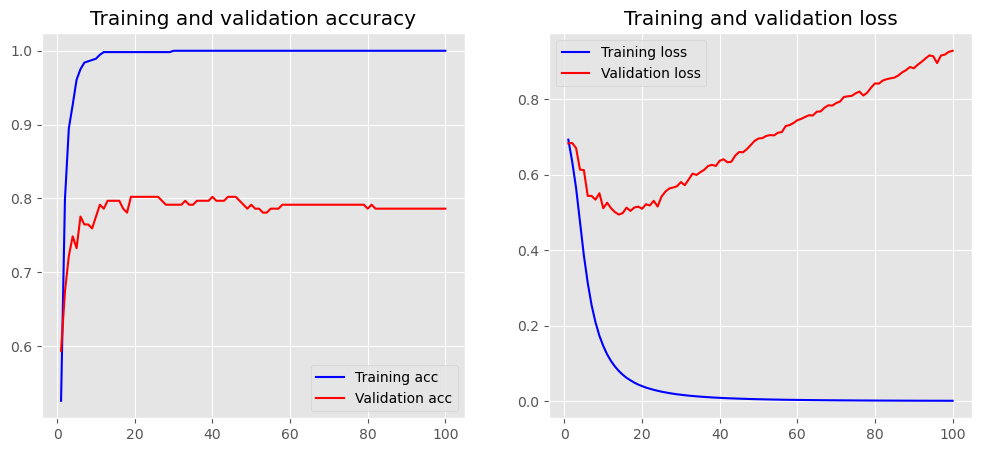

In [32]:
# Train the model
from keras.backend import clear_session

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

clear_session()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

### Neural Network with Simple Index-based Embedding

For embedding in this case, we use `Kera's Tokenizer`, which first calculates the vocabulary as the distinct words in all the training sentences, and then assigns each one of them an index used to identify them. Then each sentence is converted to an array of indexs to represent it. To ensure the dimensions of each sentence are the same, we manually define the `maxlen` parameter and then pad the arrays accordingly. 

- This approach is a bit different from the previous one as here the input is in the form of a 2D matrix, in constrast to the one dimension of count earlier. Thus we need to include a `Flatten` layer in the architecture. 

In [33]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

# Each word is now mapped to an integer index
for word in ["the", "all", "best", "bad"]:
    print("{}: {}".format(word, tokenizer.word_index[word]))

the: 1
all: 27
best: 72
bad: 30


In [34]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 178771 (698.32 KB)
Trainable params: 178771 (698.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.6524


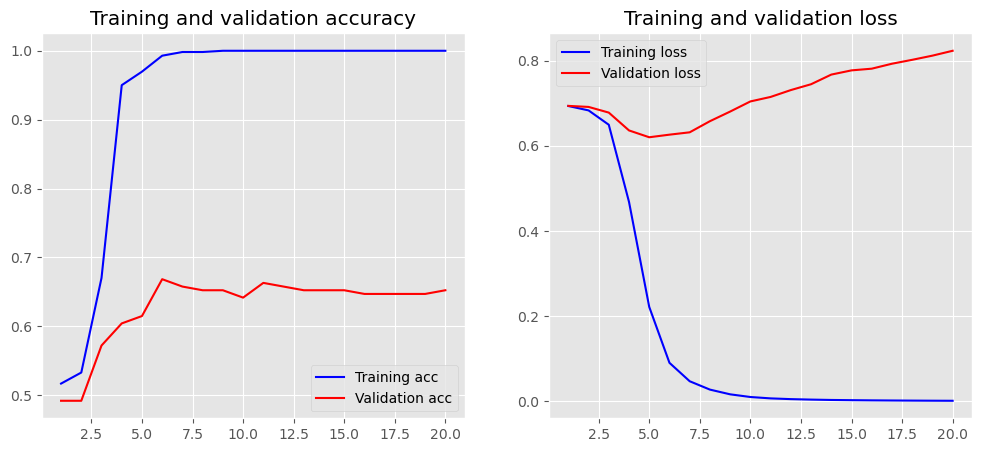

In [35]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
# input_dim is the size of the vocabulary
# input_length is the length of the input sequences (maxlen)
model.add(
    layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen
    )
)
# We need to add a Flatten layer to flatten the 2D matrix into a 1D vector
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

### Introduce MaxPooling

`Max Pooling` is a pooling operation that calculates the maximum value for patches of a feature map, and uses it to create a downsampled (pooled) feature map. We introduce it here in hopes of increasing the performance.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129271 (504.96 KB)
Trainable params: 129271 (504.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.7807


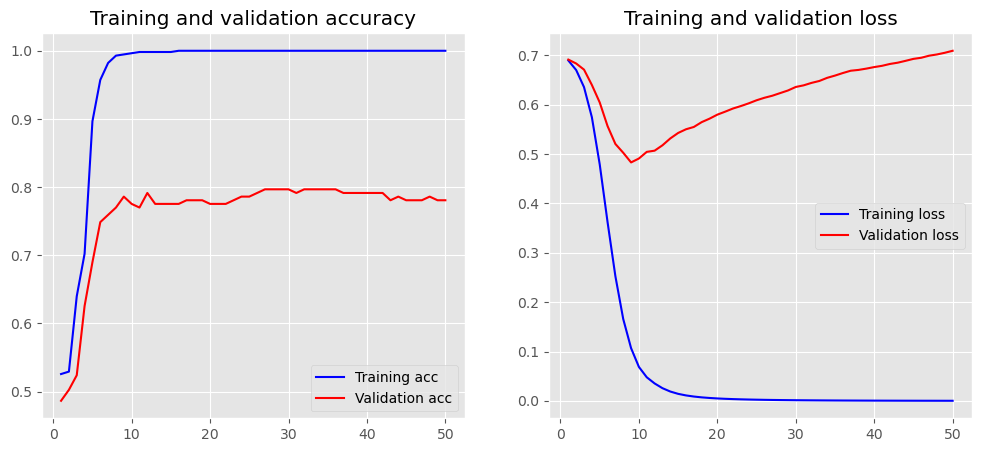

In [36]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(
    layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen
    )
)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

### GloVe Word Embedding

We now explore the alternative to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. We would be using `GloVe` (Global Vectors for Word Representation) developed by the `Stanford NLP Group`.

GloVe achieves embedding with a co-occurrence matrix and by using matrix factorization. I have used the `50 dimensional word embedding` by GloVe trained on a dataset of `6 billion words` which can be downloaded from [here](https://nlp.stanford.edu/projects/glove/).

Percentage of words convered by the embedding: 95.22330097087378
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129271 (504.96 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 128750 (502.93 KB)
_________________________________________________________________
Training Accura

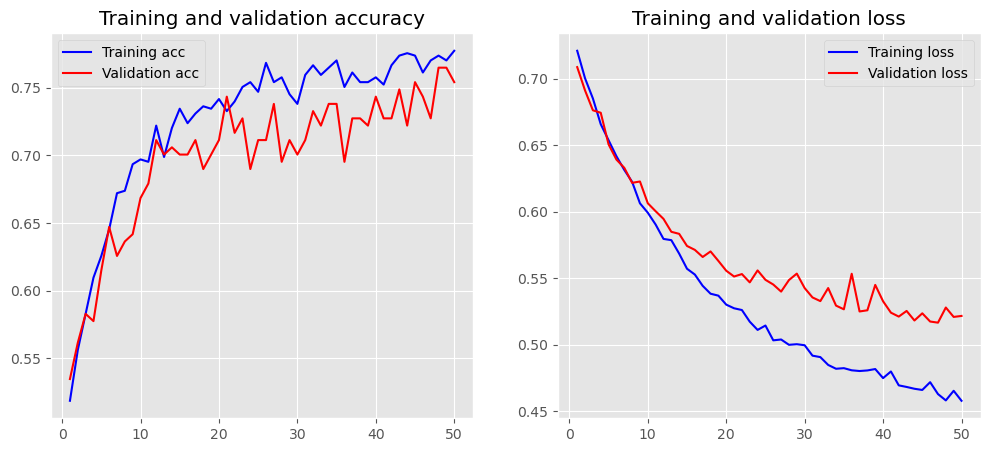

In [37]:
import numpy as np


# A helper function which reads the file from `filepath` and creates an embedding matrix of `embedding_dim` with only the words in `word_index`
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[
                    :embedding_dim
                ]

    return embedding_matrix


# Create the embedding matrix using GloVe 50-dimension embedding
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    "data/embedding/glove.6B.50d.txt", tokenizer.word_index, embedding_dim
)

# Calculate the percentage of words that are covered by the GloVe embedding
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Percentage of words convered by the embedding: {100 * nonzero_elements / vocab_size}")

# Create, train and evaluate the model
model = Sequential()
model.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False,
    )
)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)